# Data Imports

In [7]:
import requests
import pandas as pd
import time
import seaborn as sns

In [ ]:
# Step 1: Get bootstrap data (teams, players)
bootstrap_url = 'https://fantasy.premierleague.com/api/bootstrap-static/'
bootstrap_data = requests.get(bootstrap_url).json()

players_df = pd.DataFrame(bootstrap_data['elements'])
teams_df = pd.DataFrame(bootstrap_data['teams'])

# Step 2: Get all fixtures separately
fixtures_url = 'https://fantasy.premierleague.com/api/fixtures/'
all_fixtures = pd.DataFrame(requests.get(fixtures_url).json())

# Step 3: Get player histories with team context
all_player_histories = []

for player_id in players_df['id']:
    try:
        url = f'https://fantasy.premierleague.com/api/element-summary/{player_id}/'
        response = requests.get(url)
        player_data = response.json()
        
        # Get history
        history = pd.DataFrame(player_data['history'])
        if len(history) == 0:
            continue
            
        history['player_id'] = player_id
        all_player_histories.append(history)
        
        time.sleep(0.1)  # Be nice to the API
        
        # Print progress every 50 players
        if player_id % 50 == 0:
            print(f"Processed {player_id} players...")
        
    except Exception as e:
        print(f"Error with player {player_id}: {e}")
        continue

print(f"Finished collecting data for {len(all_player_histories)} players")

# Combine all histories
history_df = pd.concat(all_player_histories, ignore_index=True)

# IMPORTANT: Convert numeric columns to proper types
numeric_cols = ['total_points', 'minutes', 'goals_scored', 'assists', 'clean_sheets',
                'goals_conceded', 'saves', 'bonus', 'bps', 'yellow_cards', 'red_cards',
                'own_goals', 'penalties_saved', 'penalties_missed',
                'expected_goals', 'expected_assists', 'expected_goal_involvements',
                'expected_goals_conceded', 'influence', 'creativity', 'threat', 
                'ict_index', 'tackles', 'clearances_blocks_interceptions', 'recoveries',
                'selected', 'transfers_in', 'transfers_out', 'transfers_balance', 'value']

for col in numeric_cols:
    if col in history_df.columns:
        history_df[col] = pd.to_numeric(history_df[col], errors='coerce')

# Step 4: Add player info (name, team, position)
history_df = history_df.merge(
    players_df[['id', 'web_name', 'team', 'element_type', 'now_cost']], 
    left_on='player_id', 
    right_on='id',
    how='left'
)

# Step 4b: Add readable position names
# FPL position codes: 1=GK, 2=DEF, 3=MID, 4=FWD
position_map = {
    1: 'GK',
    2: 'DEF',
    3: 'MID',
    4: 'FWD'
}
history_df['position'] = history_df['element_type'].map(position_map)

# Step 5: Add player's team name and info
history_df = history_df.merge(
    teams_df[['id', 'name', 'short_name', 'strength', 'strength_overall_home', 
              'strength_overall_away', 'strength_attack_home', 'strength_attack_away',
              'strength_defence_home', 'strength_defence_away']],
    left_on='team',
    right_on='id',
    how='left',
    suffixes=('', '_team_info')
)

# Step 6: Add opponent team info
history_df = history_df.merge(
    teams_df[['id', 'name', 'short_name', 'strength', 'strength_overall_home', 
              'strength_overall_away', 'strength_attack_home', 'strength_attack_away',
              'strength_defence_home', 'strength_defence_away']],
    left_on='opponent_team',
    right_on='id',
    how='left',
    suffixes=('_player_team', '_opponent')
)

# Step 7: Calculate rolling stats (last 3, 5 gameweeks)
history_df = history_df.sort_values(['player_id', 'round'])

# Rolling points
history_df['points_last_3gw'] = history_df.groupby('player_id')['total_points'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)
history_df['points_last_5gw'] = history_df.groupby('player_id')['total_points'].transform(
    lambda x: x.rolling(window=5, min_periods=1).mean()
)

# Rolling minutes (to predict playing time)
history_df['minutes_last_3gw'] = history_df.groupby('player_id')['minutes'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)

# Rolling goals
history_df['goals_last_3gw'] = history_df.groupby('player_id')['goals_scored'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)

# Rolling assists
history_df['assists_last_3gw'] = history_df.groupby('player_id')['assists'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)

# Rolling xG (expected goals)
history_df['xg_last_3gw'] = history_df.groupby('player_id')['expected_goals'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)

# Rolling xA (expected assists)
history_df['xa_last_3gw'] = history_df.groupby('player_id')['expected_assists'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)

# Rolling xGI (expected goal involvements)
history_df['xgi_last_3gw'] = history_df.groupby('player_id')['expected_goal_involvements'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)

# Rolling clean sheets (for defenders/keepers)
history_df['clean_sheets_last_3gw'] = history_df.groupby('player_id')['clean_sheets'].transform(
    lambda x: x.rolling(window=3, min_periods=1).sum()
)

# Rolling bonus points
history_df['bonus_last_3gw'] = history_df.groupby('player_id')['bonus'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)

# Step 8: Add team form (team's average points in last few games)
team_points_by_gw = history_df.groupby(['team', 'round'])['total_points'].sum().reset_index()
team_points_by_gw.columns = ['team', 'round', 'team_total_points']

team_points_by_gw = team_points_by_gw.sort_values(['team', 'round'])
team_points_by_gw['team_form_last_3gw'] = team_points_by_gw.groupby('team')['team_total_points'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)

# Merge team form back
history_df = history_df.merge(
    team_points_by_gw[['team', 'round', 'team_form_last_3gw']],
    on=['team', 'round'],
    how='left'
)

# Step 9: Add fixture difficulty from opponent strength
history_df['fixture_difficulty'] = history_df.apply(
    lambda row: row['strength_defence_home_opponent'] if row['was_home'] 
    else row['strength_defence_away_opponent'],
    axis=1
)

# Step 10: Calculate performance metrics
# Goals vs expected goals (overperformance/underperformance)
history_df['goals_vs_xg'] = history_df['goals_scored'] - history_df['expected_goals']

# Assists vs expected assists
history_df['assists_vs_xa'] = history_df['assists'] - history_df['expected_assists']

# ICT index per 90 minutes (to normalize for playing time)
history_df['ict_per_90'] = history_df.apply(
    lambda row: (row['ict_index'] / row['minutes'] * 90) if row['minutes'] > 0 else 0,
    axis=1
)

# Step 11: Clean up column names
history_df = history_df.rename(columns={
    'web_name': 'player_name',
    'round': 'gameweek',
    'name_player_team': 'team_name',
    'short_name_player_team': 'team_short',
    'name_opponent': 'opponent_name',
    'short_name_opponent': 'opponent_short',
    'total_points': 'points'
})

# Step 12: Select comprehensive columns for your model
final_df = history_df[[
    # Identifiers
    'player_id', 'player_name', 'position', 'element_type', 'gameweek', 'fixture',
    
    # Match context
    'team_name', 'team_short', 'opponent_name', 'opponent_short', 'was_home',
    
    # Core performance stats (actual)
    'points', 'minutes', 'goals_scored', 'assists', 'clean_sheets', 'bonus',
    'goals_conceded', 'saves', 'yellow_cards', 'red_cards',
    'own_goals', 'penalties_saved', 'penalties_missed',
    
    # Expected stats (underlying metrics)
    'expected_goals', 'expected_assists', 'expected_goal_involvements',
    'expected_goals_conceded',
    
    # Advanced metrics
    'influence', 'creativity', 'threat', 'ict_index',
    'bps',  # bonus point system
    'tackles', 'clearances_blocks_interceptions', 'recoveries',
    
    # Performance vs expectation
    'goals_vs_xg', 'assists_vs_xa', 'ict_per_90',
    
    # Rolling form (last 3 gameweeks)
    'points_last_3gw', 'points_last_5gw',
    'minutes_last_3gw', 
    'goals_last_3gw', 'assists_last_3gw',
    'xg_last_3gw', 'xa_last_3gw', 'xgi_last_3gw',
    'clean_sheets_last_3gw', 'bonus_last_3gw',
    
    # Team context
    'team_form_last_3gw',
    
    # Fixture difficulty
    'fixture_difficulty',
    'strength_overall_home_player_team', 'strength_overall_away_player_team',
    'strength_attack_home_player_team', 'strength_attack_away_player_team',
    'strength_defence_home_opponent', 'strength_defence_away_opponent',
    
    # Player info
    'now_cost',
    
    # Transfer data (popularity/ownership signals)
    'selected', 'transfers_in', 'transfers_out', 'transfers_balance'
]]

# Save it!
final_df.to_csv('fpl_enriched_history.csv', index=False)

Processed 700 players...
Processed 50 players...
Processed 200 players...
Processed 100 players...
Processed 150 players...
Processed 250 players...
Processed 300 players...
Processed 350 players...
Processed 400 players...
Processed 450 players...
Processed 500 players...
Processed 550 players...
Processed 600 players...
Processed 650 players...
Finished collecting data for 743 players

Total records: 5073

Position breakdown:
position
MID    2257
DEF    1677
GK      589
FWD     550
Name: count, dtype: int64

Sample of the data:
   player_id   player_name position  element_type  gameweek  fixture  \
0          1          Raya       GK             1         1        9   
1          1          Raya       GK             1         2       11   
2          1          Raya       GK             1         3       25   
3          1          Raya       GK             1         4       31   
4          1          Raya       GK             1         5       41   
5          1          Raya      

# Loading data from CSV

In [ ]:
final_df = pd.read_csv('fpl_enriched_history.csv')

# Exploration

## Affect of home games on points

<Axes: xlabel='was_home', ylabel='points'>

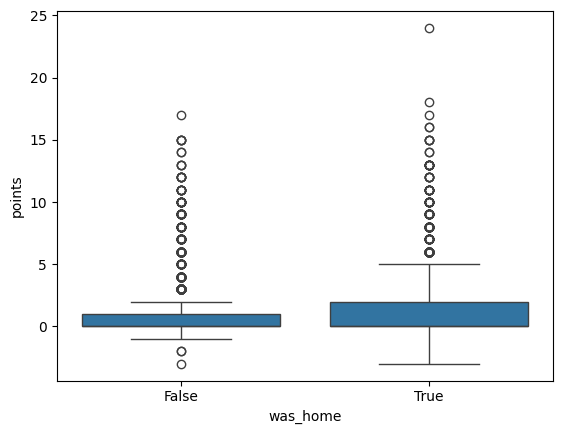

In [9]:
sns.boxplot(data=final_df,x='was_home',y='points')

It seems like there is some influence on the standard deviation of points gained based on whether the players play at home or not.

0.44318914310573526


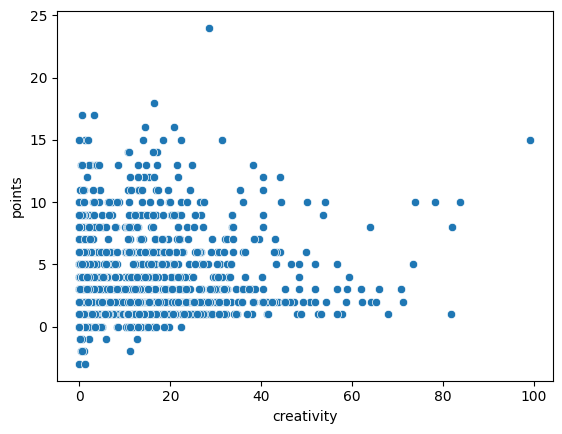

In [12]:
sns.scatterplot(data = final_df, x = 'creativity', y = 'points')
correlation = final_df['creativity'].corr(final_df['points'])
print(correlation)

There is a correlation of {{ correlation }}